In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
from numpy import polyfit
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('/content/drive/My Drive/OIL_CrUDE/DCOILWTICO.csv')

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
#Use the last available price to fill in missing data (since oil prices don’t change on closed days).
df["observation_date"] = pd.to_datetime(df["observation_date"])

df['DCOILWTICO'] = df['DCOILWTICO'].fillna(method='ffill')
df.head()

,observation_date,DCOILWTICO
0,2015-06-02,61.30
1,2015-06-03,59.67
2,2015-06-04,58.00
3,2015-06-05,59.11
4,2015-06-08,58.15


In [4]:
import pandas as pd
import yfinance as yf

crude = yf.download('CL=F', start='2015-06-02', end='2025-06-02')
crude.reset_index(inplace=True)

crude['Date'] = pd.to_datetime(crude['Date'])

crude.set_index('Date', inplace=True)





YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:

crude = yf.download('CL=F', start='2015-06-02', end='2025-06-02')
crude.reset_index(inplace=True)

crude['Date'] = pd.to_datetime(crude['Date'])
crude.rename(columns={'Date': 'observation_date'}, inplace=True)

if isinstance(crude.columns, pd.MultiIndex):
    crude.columns = crude.columns.get_level_values(0)

df['observation_date'] = pd.to_datetime(df['observation_date'])
df = df.merge(crude[['observation_date', 'Volume']], on='observation_date', how='left')

df['Volume'] = df['Volume'].fillna(method='ffill')

[*********************100%***********************]  1 of 1 completed


In [7]:
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.utils import dropna

df= dropna(df)

rsi = RSIIndicator(close=df["DCOILWTICO"])
df["RSI"] = rsi.rsi()

macd = MACD(close=df["DCOILWTICO"])
df["MACD"] = macd.macd()
df["MACD_Signal"] = macd.macd_signal()

df["MA10"] = df["DCOILWTICO"].rolling(window=10).mean()
df["MA50"] = df["DCOILWTICO"].rolling(window=50).mean()

bollinger = BollingerBands(close=df["DCOILWTICO"])
df["BB_High"] = bollinger.bollinger_hband()
df["BB_Low"] = bollinger.bollinger_lband()




In [8]:
df=df.drop(['MACD_Signal','MA50','BB_High','BB_Low'],axis=1)
df.head()

,observation_date,DCOILWTICO,Volume,RSI,MACD,MA10
0,2015-06-02,61.30,344508.0,NaN,NaN,NaN
1,2015-06-03,59.67,371298.0,NaN,NaN,NaN
2,2015-06-04,58.00,363345.0,NaN,NaN,NaN
3,2015-06-05,59.11,461016.0,NaN,NaN,NaN
4,2015-06-08,58.15,339845.0,NaN,NaN,NaN


# CNN+LSTM+Transformers

# Fine Tunning

In [ ]:
!pip install optuna


In [11]:
njimport pandas as pd
from sklearn.preprocessing import MinMaxScaler

features = [
    'DCOILWTICO', 'Volume', 'MA10', 'RSI', 'MACD'
]

df[features] = df[features].fillna(method='ffill')
df = df.dropna(subset=features)

train = df.iloc[:1950]
valid = df.iloc[1950:2300]
test = df.iloc[2300:]

scaler = MinMaxScaler()

train_data = scaler.fit_transform(train[features])
valid_data = scaler.transform(valid[features])
test_data = scaler.transform(test[features])

print("Train data shape:", train_data.shape)
print("Validation data shape:", valid_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (1950, 5)
Validation data shape: (350, 5)
Test data shape: (283, 5)


In [ ]:
import optuna
import tensorflow as tf
from tensorflow.keras import layers, backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def create_sequences(data, seq_length, target_column_idx=None):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        if target_column_idx is None:
            y.append(data[i+seq_length])
        else:
            y.append(data[i+seq_length][target_column_idx])
    return np.array(X), np.array(y)

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def mase(y_true, y_pred, y_train):
    n = len(y_train)
    d = np.mean(np.abs(np.diff(y_train)))
    errors = np.abs(y_true - y_pred)
    return errors.mean() / d

def objective(trial):
    seq_length = trial.suggest_int('seq_length', 5, 20)
    lstm_units = trial.suggest_int('lstm_units', 32, 256)
    num_heads = trial.suggest_int('num_heads', 2, 8)
    ff_dim = trial.suggest_int('ff_dim', 64, 256)
    dropout_rate = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_float('lr', 1e-4, 1e-2, log=True)

    X_train, y_train = create_sequences(train_data, seq_length, target_col)
    X_val, y_val = create_sequences(valid_data, seq_length, target_col)

    input_shape = (X_train.shape[1], X_train.shape[2])

    class TransformerEncoder(layers.Layer):
        def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
            super().__init__()
            self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
            self.ffn = tf.keras.Sequential([
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ])
            self.layernorm1 = layers.LayerNormalization()
            self.layernorm2 = layers.LayerNormalization()
            self.dropout1 = layers.Dropout(rate)
            self.dropout2 = layers.Dropout(rate)

        def call(self, inputs, training=False):
            attn_output = self.att(inputs, inputs)
            out1 = self.layernorm1(inputs + self.dropout1(attn_output, training=training))
            ffn_output = self.ffn(out1)
            return self.layernorm2(out1 + self.dropout2(ffn_output, training=training))

    inputs = layers.Input(shape=input_shape)

    x = layers.Conv1D(128, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(lstm_units // 2, return_sequences=True))(x)

    x = TransformerEncoder(embed_dim=int(x.shape[-1]), num_heads=num_heads, ff_dim=ff_dim, rate=dropout_rate)(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        verbose=0,
        callbacks=[early_stop]
    )

    val_pred = model.predict(X_val).flatten()

    rmse = mean_squared_error(y_val, val_pred)
    mse = mean_squared_error(y_val, val_pred)
    mae = mean_absolute_error(y_val, val_pred)
    r2 = r2_score(y_val, val_pred)
    smape_val = smape(y_val, val_pred)
    mase_val = mase(y_val, val_pred, y_train)

    print(f"Trial {trial.number} -- RMSE: {rmse:.5f}, MSE: {mse:.5f}, MAE: {mae:.5f}, R2: {r2:.5f}, sMAPE: {smape_val:.3f}%, MASE: {mase_val:.5f}")

    # Store metrics to retrieve later
    trial.set_user_attr('mse', mse)
    trial.set_user_attr('mae', mae)
    trial.set_user_attr('r2', r2)
    trial.set_user_attr('smape', smape_val)
    trial.set_user_attr('mase', mase_val)

    K.clear_session()

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

best_trial = study.best_trial

print("Best trial metrics:")
print(f"RMSE: {best_trial.value}")
print(f"MSE: {best_trial.user_attrs['mse']}")
print(f"MAE: {best_trial.user_attrs['mae']}")
print(f"R2: {best_trial.user_attrs['r2']}")
print(f"sMAPE: {best_trial.user_attrs['smape']}")
print(f"MASE: {best_trial.user_attrs['mase']}")
print(f"Best hyperparameters: {best_trial.params}")


[I 2025-06-15 08:04:56,646] A new study created in memory with name: no-name-f0b10758-3987-4fe1-aff8-f93c9acebe6a


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Trial 0 -- RMSE: 0.00032, MSE: 0.00032, MAE: 0.01394, R2: 0.76089, sMAPE: 1.948%, MASE: 2.01833


[I 2025-06-15 08:05:34,943] Trial 0 finished with value: 0.00031530366571615707 and parameters: {'seq_length': 14, 'lstm_units': 85, 'num_heads': 5, 'ff_dim': 223, 'dropout': 0.16433221481910124, 'lr': 0.0022685555464691887}. Best is trial 0 with value: 0.00031530366571615707.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Trial 1 -- RMSE: 0.00043, MSE: 0.00043, MAE: 0.01630, R2: 0.66884, sMAPE: 2.259%, MASE: 2.35210


[I 2025-06-15 08:06:11,929] Trial 1 finished with value: 0.0004282844134534899 and parameters: {'seq_length': 6, 'lstm_units': 241, 'num_heads': 3, 'ff_dim': 222, 'dropout': 0.17367236219445795, 'lr': 0.00296282804608005}. Best is trial 0 with value: 0.00031530366571615707.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Trial 2 -- RMSE: 0.00034, MSE: 0.00034, MAE: 0.01432, R2: 0.74067, sMAPE: 2.005%, MASE: 2.07326


[I 2025-06-15 08:07:03,595] Trial 2 finished with value: 0.0003381350137618922 and parameters: {'seq_length': 9, 'lstm_units': 249, 'num_heads': 3, 'ff_dim': 88, 'dropout': 0.41772314161284085, 'lr': 0.0004121143965312394}. Best is trial 0 with value: 0.00031530366571615707.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Trial 3 -- RMSE: 0.00039, MSE: 0.00039, MAE: 0.01554, R2: 0.70246, sMAPE: 2.161%, MASE: 2.24870


[I 2025-06-15 08:08:07,212] Trial 3 finished with value: 0.0003934663707195972 and parameters: {'seq_length': 15, 'lstm_units': 184, 'num_heads': 3, 'ff_dim': 243, 'dropout': 0.48598793046607136, 'lr': 0.0012298752013689966}. Best is trial 0 with value: 0.00031530366571615707.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
Trial 4 -- RMSE: 0.00039, MSE: 0.00039, MAE: 0.01591, R2: 0.69864, sMAPE: 2.227%, MASE: 2.30612


[I 2025-06-15 08:09:07,658] Trial 4 finished with value: 0.00039397231484452803 and parameters: {'seq_length': 10, 'lstm_units': 238, 'num_heads': 8, 'ff_dim': 229, 'dropout': 0.2690872621650775, 'lr': 0.00022690337531808152}. Best is trial 0 with value: 0.00031530366571615707.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Trial 5 -- RMSE: 0.00039, MSE: 0.00039, MAE: 0.01587, R2: 0.69906, sMAPE: 2.213%, MASE: 2.30026


[I 2025-06-15 08:09:42,711] Trial 5 finished with value: 0.00039343149539743463 and parameters: {'seq_length': 10, 'lstm_units': 92, 'num_heads': 8, 'ff_dim': 103, 'dropout': 0.2036512811834623, 'lr': 0.0002529467330876886}. Best is trial 0 with value: 0.00031530366571615707.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Trial 6 -- RMSE: 0.00029, MSE: 0.00029, MAE: 0.01350, R2: 0.77733, sMAPE: 1.886%, MASE: 1.95320


[I 2025-06-15 08:10:58,626] Trial 6 finished with value: 0.00029445759545443487 and parameters: {'seq_length': 15, 'lstm_units': 206, 'num_heads': 4, 'ff_dim': 65, 'dropout': 0.16355415072242888, 'lr': 0.0003175952852940278}. Best is trial 6 with value: 0.00029445759545443487.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Trial 7 -- RMSE: 0.00019, MSE: 0.00019, MAE: 0.01091, R2: 0.85639, sMAPE: 1.533%, MASE: 1.57889


[I 2025-06-15 08:12:07,418] Trial 7 finished with value: 0.0001872472019174284 and parameters: {'seq_length': 9, 'lstm_units': 48, 'num_heads': 6, 'ff_dim': 217, 'dropout': 0.17875360440356808, 'lr': 0.0006980519533981587}. Best is trial 7 with value: 0.0001872472019174284.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Trial 8 -- RMSE: 0.00023, MSE: 0.00023, MAE: 0.01170, R2: 0.82619, sMAPE: 1.636%, MASE: 1.69469


[I 2025-06-15 08:12:58,213] Trial 8 finished with value: 0.00022864471670077532 and parameters: {'seq_length': 13, 'lstm_units': 48, 'num_heads': 7, 'ff_dim': 198, 'dropout': 0.34046263509728575, 'lr': 0.0014008656370707545}. Best is trial 7 with value: 0.0001872472019174284.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Trial 9 -- RMSE: 0.00032, MSE: 0.00032, MAE: 0.01412, R2: 0.75656, sMAPE: 1.961%, MASE: 2.03999


[I 2025-06-15 08:13:40,182] Trial 9 finished with value: 0.000315758373922617 and parameters: {'seq_length': 7, 'lstm_units': 127, 'num_heads': 3, 'ff_dim': 68, 'dropout': 0.33888039657667324, 'lr': 0.006104988004365035}. Best is trial 7 with value: 0.0001872472019174284.


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step
Trial 10 -- RMSE: 0.00029, MSE: 0.00029, MAE: 0.01358, R2: 0.78196, sMAPE: 1.911%, MASE: 1.96633


[I 2025-06-15 08:14:35,384] Trial 10 finished with value: 0.0002908791413683463 and parameters: {'seq_length': 18, 'lstm_units': 38, 'num_heads': 6, 'ff_dim': 159, 'dropout': 0.2581534587514386, 'lr': 0.0001101911238259691}. Best is trial 7 with value: 0.0001872472019174284.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Trial 11 -- RMSE: 0.00019, MSE: 0.00019, MAE: 0.01104, R2: 0.85413, sMAPE: 1.550%, MASE: 1.59939


[I 2025-06-15 08:15:40,460] Trial 11 finished with value: 0.0001913981395606533 and parameters: {'seq_length': 12, 'lstm_units': 33, 'num_heads': 6, 'ff_dim': 182, 'dropout': 0.3657780340335919, 'lr': 0.0007827719460038212}. Best is trial 7 with value: 0.0001872472019174284.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Trial 12 -- RMSE: 0.00041, MSE: 0.00041, MAE: 0.01610, R2: 0.68898, sMAPE: 2.248%, MASE: 2.33385


[I 2025-06-15 08:16:25,897] Trial 12 finished with value: 0.00040717817664898587 and parameters: {'seq_length': 11, 'lstm_units': 79, 'num_heads': 6, 'ff_dim': 168, 'dropout': 0.40065537065939677, 'lr': 0.0005443526530491421}. Best is trial 7 with value: 0.0001872472019174284.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Trial 13 -- RMSE: 0.00014, MSE: 0.00014, MAE: 0.00924, R2: 0.89621, sMAPE: 1.289%, MASE: 1.33850


[I 2025-06-15 08:17:32,264] Trial 13 finished with value: 0.00013846291942247864 and parameters: {'seq_length': 18, 'lstm_units': 35, 'num_heads': 6, 'ff_dim': 177, 'dropout': 0.11947778176649274, 'lr': 0.0007252552292121351}. Best is trial 13 with value: 0.00013846291942247864.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
Trial 14 -- RMSE: 0.00025, MSE: 0.00025, MAE: 0.01228, R2: 0.81222, sMAPE: 1.708%, MASE: 1.77817


[I 2025-06-15 08:18:27,879] Trial 14 finished with value: 0.00025190229284550867 and parameters: {'seq_length': 20, 'lstm_units': 128, 'num_heads': 5, 'ff_dim': 141, 'dropout': 0.10264683757088403, 'lr': 0.0007838201409862848}. Best is trial 13 with value: 0.00013846291942247864.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Trial 15 -- RMSE: 0.00049, MSE: 0.00049, MAE: 0.01748, R2: 0.63254, sMAPE: 2.454%, MASE: 2.53108


[I 2025-06-15 08:19:13,038] Trial 15 finished with value: 0.0004888294181006041 and parameters: {'seq_length': 17, 'lstm_units': 67, 'num_heads': 7, 'ff_dim': 132, 'dropout': 0.12330485976956011, 'lr': 0.002341416218180232}. Best is trial 13 with value: 0.00013846291942247864.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Trial 16 -- RMSE: 0.00042, MSE: 0.00042, MAE: 0.01658, R2: 0.67396, sMAPE: 2.308%, MASE: 2.39255


[I 2025-06-15 08:19:57,602] Trial 16 finished with value: 0.00042044790863239633 and parameters: {'seq_length': 5, 'lstm_units': 161, 'num_heads': 7, 'ff_dim': 197, 'dropout': 0.24523725335287067, 'lr': 0.00015152078102996101}. Best is trial 13 with value: 0.00013846291942247864.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Trial 17 -- RMSE: 0.00026, MSE: 0.00026, MAE: 0.01253, R2: 0.80815, sMAPE: 1.752%, MASE: 1.81352


[I 2025-06-15 08:20:55,981] Trial 17 finished with value: 0.00025660534498774955 and parameters: {'seq_length': 19, 'lstm_units': 110, 'num_heads': 4, 'ff_dim': 254, 'dropout': 0.2128460165475634, 'lr': 0.006088253029058707}. Best is trial 13 with value: 0.00013846291942247864.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Trial 18 -- RMSE: 0.00013, MSE: 0.00013, MAE: 0.00890, R2: 0.90031, sMAPE: 1.248%, MASE: 1.28735


[I 2025-06-15 08:22:11,256] Trial 18 finished with value: 0.00012964783325436884 and parameters: {'seq_length': 8, 'lstm_units': 65, 'num_heads': 6, 'ff_dim': 196, 'dropout': 0.1294905930658956, 'lr': 0.0005653838634579425}. Best is trial 18 with value: 0.00012964783325436884.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Trial 19 -- RMSE: 0.00020, MSE: 0.00020, MAE: 0.01075, R2: 0.85152, sMAPE: 1.508%, MASE: 1.55715


[I 2025-06-15 08:23:21,155] Trial 19 finished with value: 0.00019751716877613112 and parameters: {'seq_length': 17, 'lstm_units': 68, 'num_heads': 2, 'ff_dim': 140, 'dropout': 0.12669240799388776, 'lr': 0.0014727785003358733}. Best is trial 18 with value: 0.00012964783325436884.


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step
Trial 20 -- RMSE: 0.00017, MSE: 0.00017, MAE: 0.01012, R2: 0.87223, sMAPE: 1.418%, MASE: 1.46238


[I 2025-06-15 08:24:33,436] Trial 20 finished with value: 0.00016571693559284004 and parameters: {'seq_length': 7, 'lstm_units': 108, 'num_heads': 5, 'ff_dim': 195, 'dropout': 0.13548135815990234, 'lr': 0.0004512325216670192}. Best is trial 18 with value: 0.00012964783325436884.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Trial 21 -- RMSE: 0.00026, MSE: 0.00026, MAE: 0.01309, R2: 0.79760, sMAPE: 1.834%, MASE: 1.89157


[I 2025-06-15 08:25:20,052] Trial 21 finished with value: 0.00026251508245475993 and parameters: {'seq_length': 7, 'lstm_units': 105, 'num_heads': 5, 'ff_dim': 196, 'dropout': 0.10035576365905427, 'lr': 0.0004373206038384133}. Best is trial 18 with value: 0.00012964783325436884.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Trial 22 -- RMSE: 0.00014, MSE: 0.00014, MAE: 0.00916, R2: 0.89359, sMAPE: 1.284%, MASE: 1.32441


[I 2025-06-15 08:26:36,372] Trial 22 finished with value: 0.00013838635695965153 and parameters: {'seq_length': 8, 'lstm_units': 56, 'num_heads': 5, 'ff_dim': 170, 'dropout': 0.14851656380076259, 'lr': 0.0005322155222066956}. Best is trial 18 with value: 0.00012964783325436884.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Trial 23 -- RMSE: 0.00020, MSE: 0.00020, MAE: 0.01080, R2: 0.84582, sMAPE: 1.511%, MASE: 1.56216


[I 2025-06-15 08:27:20,091] Trial 23 finished with value: 0.0002004998846936483 and parameters: {'seq_length': 8, 'lstm_units': 55, 'num_heads': 4, 'ff_dim': 162, 'dropout': 0.21356759451791923, 'lr': 0.0010520579324114201}. Best is trial 18 with value: 0.00012964783325436884.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Trial 24 -- RMSE: 0.00026, MSE: 0.00026, MAE: 0.01305, R2: 0.79613, sMAPE: 1.823%, MASE: 1.88356


[I 2025-06-15 08:27:55,086] Trial 24 finished with value: 0.0002628971662609321 and parameters: {'seq_length': 5, 'lstm_units': 62, 'num_heads': 7, 'ff_dim': 177, 'dropout': 0.14582233014472196, 'lr': 0.00017603759445469842}. Best is trial 18 with value: 0.00012964783325436884.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Trial 25 -- RMSE: 0.00031, MSE: 0.00031, MAE: 0.01370, R2: 0.76273, sMAPE: 1.914%, MASE: 1.98557


[I 2025-06-15 08:28:38,333] Trial 25 finished with value: 0.0003113140378901579 and parameters: {'seq_length': 12, 'lstm_units': 149, 'num_heads': 6, 'ff_dim': 127, 'dropout': 0.3013921708522722, 'lr': 0.0006081206945372393}. Best is trial 18 with value: 0.00012964783325436884.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Trial 26 -- RMSE: 0.00017, MSE: 0.00017, MAE: 0.01002, R2: 0.87227, sMAPE: 1.400%, MASE: 1.45183


[I 2025-06-15 08:29:53,586] Trial 26 finished with value: 0.00016698262557278708 and parameters: {'seq_length': 10, 'lstm_units': 32, 'num_heads': 5, 'ff_dim': 153, 'dropout': 0.19447832783561353, 'lr': 0.00033234250194858535}. Best is trial 18 with value: 0.00012964783325436884.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Trial 27 -- RMSE: 0.00016, MSE: 0.00016, MAE: 0.00982, R2: 0.88169, sMAPE: 1.370%, MASE: 1.42230


[I 2025-06-15 08:31:07,908] Trial 27 finished with value: 0.00015691074324411462 and parameters: {'seq_length': 16, 'lstm_units': 80, 'num_heads': 6, 'ff_dim': 184, 'dropout': 0.23525713946514148, 'lr': 0.009735864701702018}. Best is trial 18 with value: 0.00012964783325436884.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Trial 28 -- RMSE: 0.00023, MSE: 0.00023, MAE: 0.01194, R2: 0.82534, sMAPE: 1.671%, MASE: 1.72701


[I 2025-06-15 08:31:47,357] Trial 28 finished with value: 0.0002271444263403728 and parameters: {'seq_length': 8, 'lstm_units': 95, 'num_heads': 4, 'ff_dim': 174, 'dropout': 0.14517133590203632, 'lr': 0.0009569372526297382}. Best is trial 18 with value: 0.00012964783325436884.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Trial 29 -- RMSE: 0.00042, MSE: 0.00042, MAE: 0.01576, R2: 0.68507, sMAPE: 2.202%, MASE: 2.28243


[I 2025-06-15 08:32:22,125] Trial 29 finished with value: 0.00041528559656572146 and parameters: {'seq_length': 14, 'lstm_units': 78, 'num_heads': 5, 'ff_dim': 211, 'dropout': 0.2920860480971425, 'lr': 0.0015758644140431754}. Best is trial 18 with value: 0.00012964783325436884.


Best trial metrics:
RMSE: 0.00012964783325436884
MSE: 0.00012964783325436884
MAE: 0.008903898894715866
R2: 0.9003060503919056
sMAPE: 1.24832141103975
MASE: 1.2873486855960852
Best hyperparameters: {'seq_length': 8, 'lstm_units': 65, 'num_heads': 6, 'ff_dim': 196, 'dropout': 0.1294905930658956, 'lr': 0.0005653838634579425}


In [9]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [12]:
def create_sequences(data, seq_length, target_column_idx=None):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        if target_column_idx is None:
            y.append(data[i+seq_length])
        else:
            y.append(data[i+seq_length][target_column_idx])
    return np.array(X), np.array(y)


seq_length = 8
target_col = 0

X_train, y_train = create_sequences(train_data, seq_length, target_col)
X_val, y_val = create_sequences(valid_data, seq_length, target_col)
X_test, y_test = create_sequences(test_data, seq_length, target_col)

print(X_train.shape)
print(y_train.shape)

(1942, 8, 5)
(1942,)


In [ ]:
y_train

array([0.51276304, 0.51849085, 0.52129249, ..., 0.68721205, 0.69163242,
       0.7106836 ])

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# --- Transformer Encoder Class ---
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.129):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.layernorm2 = tf.keras.layers.LayerNormalization()
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + self.dropout1(attn_output, training=training))
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + self.dropout2(ffn_output, training=training))

# --- Build Hybrid Model with Best Hyperparameters ---
def build_hybrid_model(input_shape, lstm_units=65, num_heads=6, ff_dim=196, dropout_rate=0.129):
    inputs = Input(shape=input_shape)

    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    x = Bidirectional(LSTM(lstm_units // 2, return_sequences=True))(x)

    x = TransformerEncoder(embed_dim=x.shape[-1], num_heads=num_heads, ff_dim=ff_dim, rate=dropout_rate)(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model



input_shape = (X_train.shape[1], X_train.shape[2])
model = build_hybrid_model(
    input_shape=input_shape,
    lstm_units=65,
    num_heads=6,
    ff_dim=196,
    dropout_rate=0.129
)

model.compile(optimizer=Adam(learning_rate=0.000565), loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 0.6274 - mae: 0.5140 - val_loss: 0.0038 - val_mae: 0.0539 - learning_rate: 5.6500e-04
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0215 - mae: 0.1156 - val_loss: 9.3667e-04 - val_mae: 0.0250 - learning_rate: 5.6500e-04
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0114 - mae: 0.0832 - val_loss: 7.3228e-04 - val_mae: 0.0226 - learning_rate: 5.6500e-04
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0100 - mae: 0.0775 - val_loss: 6.5128e-04 - val_mae: 0.0203 - learning_rate: 5.6500e-04
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0077 - mae: 0.0688 - val_loss: 0.0056 - val_mae: 0.0724 - learning_rate: 5.6500e-04
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0070 - mae: 0.0652 - val_loss: 3.4804e-04 - val_mae: 0.0149 - learning_rate: 5.6500e-04
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0062 - mae: 0.0630 - val_loss: 3.6813e-04 - v

In [ ]:
model.save("hybrid_model.h5")


In [14]:
train_predict = model.predict(X_train)
Val_predict = model.predict(X_val)
test_predict=model.predict(X_test)

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from math import sqrt

# -------- sMAPE Function --------
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# -------- MASE Function --------
def mase(y_true, y_pred):
    mae_model = np.mean(np.abs(y_true - y_pred))
    mae_naive = np.mean(np.abs(y_true[1:] - y_true[:-1]))  # naive lag-1 forecast
    return mae_model / mae_naive

# ----------- Train Metrics -----------
train_rmse = sqrt(mean_squared_error(y_train, train_predict))
train_mse = mean_squared_error(y_train, train_predict)
train_mae = mean_absolute_error(y_train, train_predict)
train_smape = smape(y_train, train_predict)
train_mase = mase(y_train, train_predict)
train_r2 = r2_score(y_train, train_predict)

# ----------- Validation Metrics -----------
val_rmse = sqrt(mean_squared_error(y_val, Val_predict))
val_mse = mean_squared_error(y_val, Val_predict)
val_mae = mean_absolute_error(y_val, Val_predict)
val_smape = smape(y_val, Val_predict)
val_mase = mase(y_val, Val_predict)
val_r2 = r2_score(y_val, Val_predict)

# ----------- Test Metrics -----------
test_rmse = sqrt(mean_squared_error(y_test, test_predict))
test_mse = mean_squared_error(y_test, test_predict)
test_mae = mean_absolute_error(y_test, test_predict)
test_smape = smape(y_test, test_predict)
test_mase = mase(y_test, test_predict)
test_r2 = r2_score(y_test, test_predict)

# ---------- Print All ----------
print("======== Train Metrics ========")
print(f"Train RMSE: {train_rmse}")
print(f"Train MSE: {train_mse}")
print(f"Train MAE: {train_mae}")
print(f"Train sMAPE: {train_smape:.2f}%")
print(f"Train MASE: {train_mase:.3f}")
print(f"Train R² Score: {train_r2:.4f}")

print("\n======== Validation Metrics ========")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation MSE: {val_mse}")
print(f"Validation MAE: {val_mae}")
print(f"Validation sMAPE: {val_smape:.2f}%")
print(f"Validation MASE: {val_mase:.3f}")
print(f"Validation R² Score: {val_r2:.4f}")

print("\n======== Test Metrics ========")
print(f"Test RMSE: {test_rmse}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")
print(f"Test sMAPE: {test_smape:.2f}%")
print(f"Test MASE: {test_mase:.3f}")
print(f"Test R² Score: {test_r2:.4f}")


======== Train Metrics ========
Train RMSE: 0.01937607005244786
Train MSE: 0.00037543209067736685
Train MAE: 0.013042415603521032
Train sMAPE: 21.50%
Train MASE: 18.827
Train R² Score: 0.9734

======== Validation Metrics ========
Validation RMSE: 0.014257117739742054
Validation MSE: 0.00020326540624486758
Validation MAE: 0.010995152517310166
Validation sMAPE: 5.41%
Validation MASE: 5.331
Validation R² Score: 0.8439

======== Test Metrics ========
Test RMSE: 0.015098962647705905
Test MSE: 0.00022797867303681814
Test MAE: 0.01204068118171282
Test sMAPE: 6.12%
Test MASE: 6.278
Test R² Score: 0.8483


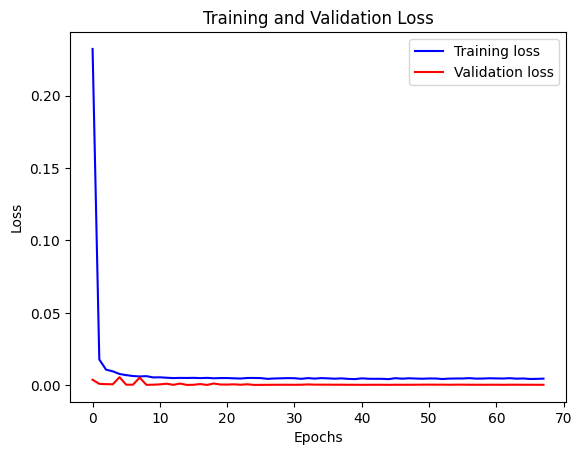

In [16]:
import matplotlib.pyplot as plt

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")



In [25]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np


target_col = 0

scaler_y = MinMaxScaler()
scaler_y.fit(train_data[:, target_col].reshape(-1, 1))

y_train_scaled = scaler_y.transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))

train_predict_inv = scaler_y.inverse_transform(train_predict)
y_train_inv = scaler_y.inverse_transform(y_train.reshape(-1, 1))

val_predict_inv = scaler_y.inverse_transform(Val_predict)
y_val_inv = scaler_y.inverse_transform(y_val.reshape(-1, 1))


y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))



test_predict_inv = scaler_y.inverse_transform(test_predict)
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))


Train dates vs y_train_inv: 1942 1942
Val dates vs y_val_inv: 342 342
Test dates vs y_test_inv: 275 275


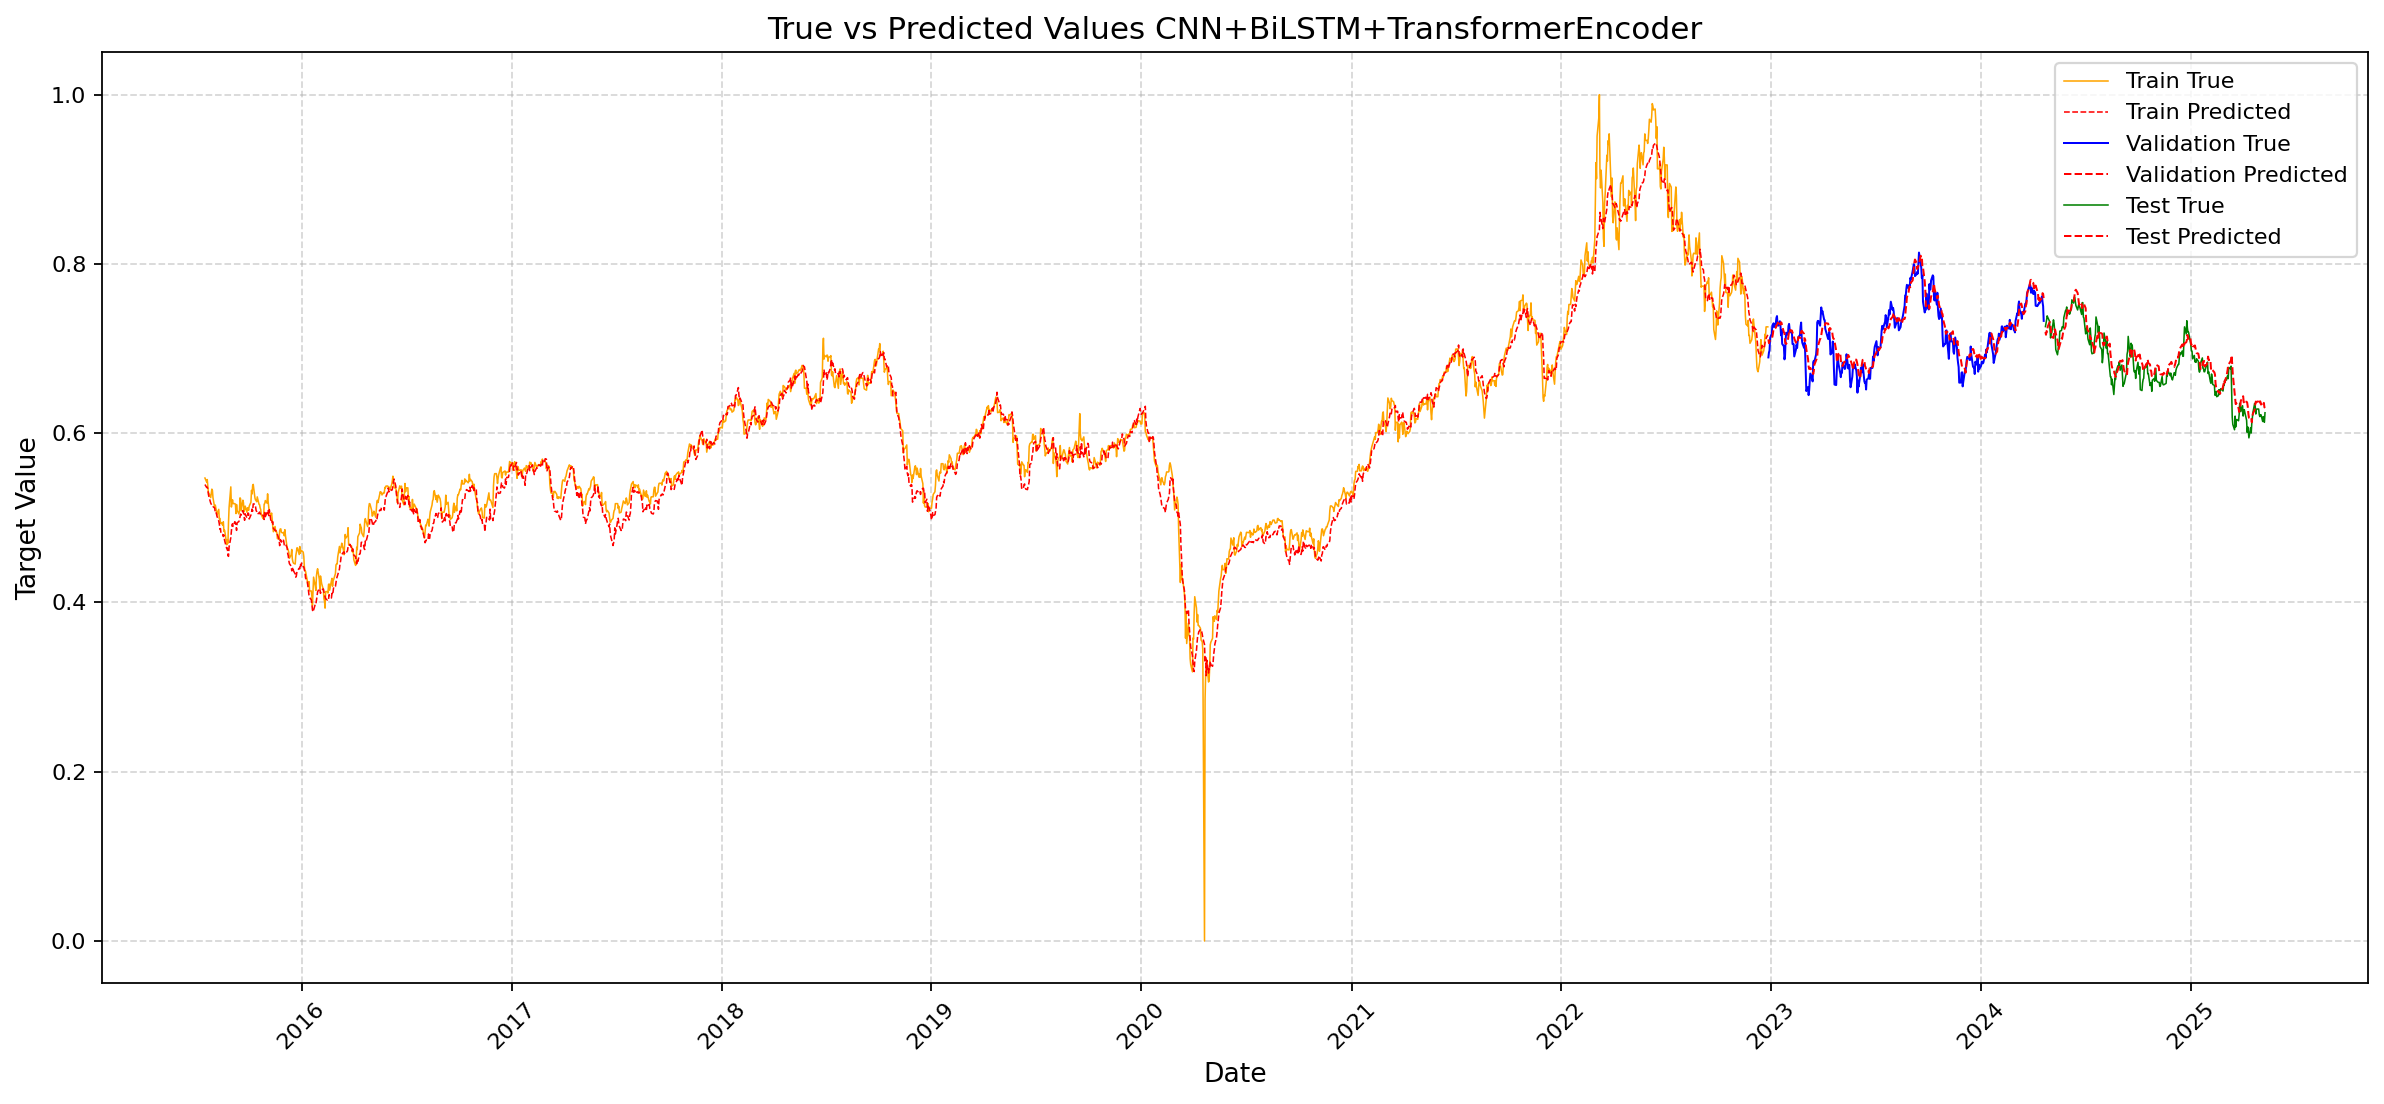

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df['observation_date'] = pd.to_datetime(df['observation_date'])

seq_length = 8

train_len = len(y_train_inv)
val_len = len(y_val_inv)
test_len = len(y_test_inv)

total_y = train_len + val_len + test_len

adjusted_dates = df['observation_date'].values[seq_length: seq_length + total_y]

train_dates = adjusted_dates[:train_len]
val_dates = adjusted_dates[train_len:train_len + val_len]
test_dates = adjusted_dates[train_len + val_len:]

print("Train dates vs y_train_inv:", len(train_dates), len(y_train_inv))
print("Val dates vs y_val_inv:", len(val_dates), len(y_val_inv))
print("Test dates vs y_test_inv:", len(test_dates), len(y_test_inv))

y_train_inv = y_train_inv.flatten()
train_predict_inv = train_predict_inv.flatten()
y_val_inv = y_val_inv.flatten()
val_predict_inv = val_predict_inv.flatten()
y_test_inv = y_test_inv.flatten()
test_predict_inv = test_predict_inv.flatten()

plt.figure(figsize=(15, 7), dpi=160)

plt.plot(train_dates, y_train_inv, label='Train True', color='orange', linewidth=0.7)
plt.plot(train_dates, train_predict_inv, label='Train Predicted', linestyle='--', color='red', linewidth=0.7)

plt.plot(val_dates, y_val_inv, label='Validation True', color='blue', linewidth=0.9)
plt.plot(val_dates, val_predict_inv, label='Validation Predicted', linestyle='--', color='red', linewidth=0.9)

plt.plot(test_dates, y_test_inv, label='Test True', color='green', linewidth=0.7)
plt.plot(test_dates, test_predict_inv, label='Test Predicted', linestyle='--', color='red', linewidth=0.9)

plt.title('True vs Predicted Values CNN+BiLSTM+TransformerEncoder', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Target Value', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
